# Multi-Factor Portfolio Analysis

Using Ken French's maintained dataset, the goal is to analyze how correlated a fund is with each of the factors. With this insight, we can build our portfolio with a better understanding of our exposure to various "effects" that have been found to be statistically significant in academic research. With this insight we can determine if our portfolios, or other managers' portfolios, are generating any alpha.

## Gathering Data

In [1]:
# Customize Pandas tables: https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import statsmodels.api as sm
import seaborn as sns
from tabulate import tabulate
import random

style.use('ggplot')

data_dir = '/Users/sam/Documents/Portfolio Projects/Stock Comparison/'

# 7/1/1926 is the furthest back the 3-factor dataset goes - Market, Value, Small
# 7/1/1963 is the furthest back the 5-factor dataset goes - Market, Value, Small, Profitability, Momentum
start = dt.datetime(1963,7,1)
end = dt.datetime.now()

def date_range(data):
    dates = data.reset_index(drop = False)
    dates['Date'] = pd.to_datetime(dates['Date'])
    start_date = dates.iloc[0,0].date()
    end_date = dates.iloc[-1,0].date()
    date_range = print(f"Date Range: {start_date} to {end_date}")

    return date_range

def fama_french_dates(fama_french):
    dates = fama_french.reset_index(drop = False)
    dates['Date'] = pd.to_datetime(dates['Date'])
    start_date = dates.iloc[0,0].date()
    end_date = dates.iloc[-1,0].date()
    date_range = print(f"Date Range: {start_date} to {end_date}")

    return date_range

def get_factors():
    factors = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily','famafrench', start, end)

    fama_french = pd.DataFrame(factors[0])

    # F-F data is percent shown as a number, need to convert to true value
    for i in fama_french:
        if i == 'Date':
            continue
        else:
            fama_french[i] = fama_french.loc[:,i]/100

    fama_french = fama_french.reset_index(drop = False)
    fama_french['Date'] = pd.to_datetime(fama_french['Date'])
    fama_french = fama_french.set_index('Date', drop = True)
    
    return fama_french

def organize_data(stocks, tickers):
    data = []

    # Create variable for each dataframe in the list
    count = 0
    for i in stocks:
        exec(f'stock_{count} = i')
        count += 1

    # Create the return series for each of the listed stocks
    count = 0
    for j in tickers:
        exec(f'stock_{count}["R_{j}"] = stock_{count}.iloc[:,0].pct_change()')
        count += 1

    # Concatenate the stock data with Fama-French data, drop missing values
    count = 0
    for i in stocks:
        exec(f'data_{count} = [i, fama_french]')
        exec(f'stock_{count} = pd.concat(data_{count}, join = "outer", axis = 1).dropna()') # concatenate & drop NAs
        exec(f'stock_{count}.iloc[:,1] = stock_{count}.iloc[:,1] - stock_{count}.loc[:,"RF"]') # subtract RF from return
        exec(f'data.append(stock_{count})') # put all of the new dataframes in the "data" list
        count += 1
    
    return data

def get_portfolio(tickers, weights):
    d = {'Ticker': tickers, 'Weight': weights}
    df = pd.DataFrame(d, columns = ['Ticker', 'Weight'])

    return df

In [2]:
fama_french = get_factors()

In [3]:
stocks = []
tickers = []
weights = []

name = input("Name your portfolio: ")

while True:
    try:
        stock = str(input('Enter a ticker, press "enter" when finished: '))
        weight = float(input('Enter its weight in the portfolio, enter 0 when finished: '))
        
        if stock == '':
            print("Funds have been added")
            break
        elif weight == 0:
            print("Funds have been added")
            break
        else:
            stock = pd.DataFrame(web.DataReader(stock, 'yahoo', start, end)['Adj Close']).rename(columns = {'Adj Close': stock.upper()})
            tickers.append(stock.columns.values[0].upper())
            stock = stock.reset_index(drop = False)
            stock['Date'] = pd.to_datetime(stock['Date'])
            stock = stock.set_index('Date', drop = True)
            stocks.append(stock)
            
            weights.append(weight)
    
    except Exception:
        print('Enter a valid ticker or weight')

Name your portfolio: IRA
Enter a ticker, press "enter" when finished: splg
Enter its weight in the portfolio, enter 0 when finished: 18
Enter a ticker, press "enter" when finished: xle
Enter its weight in the portfolio, enter 0 when finished: 5
Enter a ticker, press "enter" when finished: xlf
Enter its weight in the portfolio, enter 0 when finished: 5
Enter a ticker, press "enter" when finished: spsm
Enter its weight in the portfolio, enter 0 when finished: 10
Enter a ticker, press "enter" when finished: slyv
Enter its weight in the portfolio, enter 0 when finished: 5
Enter a ticker, press "enter" when finished: spyv
Enter its weight in the portfolio, enter 0 when finished: 10
Enter a ticker, press "enter" when finished: spyg
Enter its weight in the portfolio, enter 0 when finished: 12
Enter a ticker, press "enter" when finished: vo
Enter its weight in the portfolio, enter 0 when finished: 6
Enter a ticker, press "enter" when finished: qus
Enter its weight in the portfolio, enter 0 whe

In [4]:
data = []

# Create variable for each dataframe in the list
count = 0
for i in stocks:
    exec(f'stock_{count} = i')
    count += 1

# Create the return series for each of the listed stocks
count = 0
for j in tickers:
    exec(f'stock_{count}["R_{j}"] = stock_{count}.iloc[:,0].pct_change()')
    count += 1

# Concatenate the stock data with Fama-French data, drop missing values
count = 0
for i in stocks:
    exec(f'data_{count} = [i, fama_french]')
    exec(f'stock_{count} = pd.concat(data_{count}, join = "outer", axis = 1).dropna()') # concatenate & drop NAs
    exec(f'stock_{count}.iloc[:,1] = stock_{count}.iloc[:,1] - stock_{count}.loc[:,"RF"]') # subtract RF from return
    exec(f'data.append(stock_{count})') # put all of the new dataframes in the "data" list
    count += 1

In [5]:
# Concatenate the stock data with Fama-French data, drop missing values
count = 0
for i in stocks:
    exec(f'data_{count} = [i, fama_french]')
    exec(f'')
    count +=1

In [6]:
data = organize_data(stocks, tickers)

## Multivariate Regression
* Exogenous Variables: Mkt-RF, SMB, HML, RMW, CMA
* Endogenous Variable: R-RF (calculation already done in "data" list)

In [7]:
factor_data = pd.DataFrame()

for i in range(len(tickers)):
    x = data[i].copy()
    y = data[i].copy()
    
    x.drop(x.columns[[0,1,7]], axis = 1, inplace = True)
    x = sm.add_constant(x)
    y.drop(y.columns[[0,2,3,4,5,6,7]], axis = 1, inplace = True)
    
    reg = sm.OLS(y,x).fit()
    
    df = pd.DataFrame({
        'Ticker': [tickers[i]],
        'Alpha': [reg.params['const']],
        'T_Alpha': [reg.tvalues['const']],
        'Beta_m': [reg.params['Mkt-RF']],
        'T_Beta_m': [reg.tvalues['Mkt-RF']],
        'Beta_SMB': [reg.params['SMB']],
        'T_Beta_SMB': [reg.tvalues['SMB']],
        'Beta_HML': [reg.params['HML']],
        'T_Beta_HML': [reg.tvalues['HML']],
        'Beta_RMW': [reg.params['RMW']],
        'T_Beta_RMW': [reg.tvalues['RMW']],
        'Beta_CMA': [reg.params['CMA']],
        'T_Beta_CMA': [reg.tvalues['CMA']]
    })
    
    factor_data = factor_data.append(df)
    
factor_data = factor_data.reset_index(drop = True)

/Users/sam/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/sam/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/sam/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/sam/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/sam/opt/anaconda3/lib/python3.9/site-pack

In [8]:
port = get_portfolio(tickers, weights)
portfolio = pd.merge(port, factor_data, on = 'Ticker')
portfolio

,Ticker,Weight,Alpha,T_Alpha,Beta_m,T_Beta_m,Beta_SMB,T_Beta_SMB,Beta_HML,T_Beta_HML,Beta_RMW,T_Beta_RMW,Beta_CMA,T_Beta_CMA
0,SPLG,18.0,0.000068,0.783450,0.817354,106.079674,-0.051451,-3.533332,0.053735,4.243399,0.040322,1.861883,-0.087784,-3.020815
1,XLE,5.0,-0.000114,-0.712191,1.071699,74.336900,0.189531,7.108749,0.486211,19.653901,0.460363,13.444683,0.312207,6.891423
2,XLF,5.0,-0.000043,-0.466416,1.182336,141.416302,-0.259518,-16.784468,1.083127,75.497201,-0.141447,-7.123124,-0.388075,-14.770954
3,SPSM,10.0,-0.000027,-0.395354,0.989745,149.288335,0.843065,71.686431,0.195116,17.679121,0.120245,7.095433,0.007660,0.335215
4,SLYV,5.0,-0.000019,-0.308615,0.939979,166.553672,0.789723,73.637869,0.401271,41.768175,0.243080,17.474003,0.071874,3.945947
5,SPYV,10.0,-0.000075,-1.224930,0.886142,161.987522,-0.047081,-4.529149,0.297987,31.999786,0.162279,12.035027,0.194172,10.997941
6,SPYG,12.0,0.000012,0.143680,0.968473,129.350540,-0.081862,-5.753800,-0.175547,-13.773502,-0.049351,-2.674130,-0.151879,-6.285292
7,VO,6.0,0.000006,0.146452,1.029125,275.120711,0.191019,27.114842,0.041789,6.844659,0.018371,1.796463,-0.036859,-2.703031
8,QUS,5.0,0.000039,0.329826,0.847029,78.981063,-0.098050,-5.018149,0.067552,3.829083,0.144204,5.265165,0.045226,1.245518
9,QEFA,10.0,-0.000135,-0.875441,0.672330,46.484976,0.012880,0.495735,0.100587,4.186131,0.033503,0.900604,-0.035332,-0.712630


## CAPM Regression
* Exogenous Variables: Mkt-RF
* Endogenous Variables: R-RF (calculation already done in "data" list)

In [9]:
capm_data = pd.DataFrame()

for i in range(len(tickers)):
    capm_x = data[i].copy()
    capm_y = data[i].copy()
    
    capm_x.drop(capm_x.columns[[0,1,3,4,5,6,7]], axis = 1, inplace = True)
    capm_x = sm.add_constant(capm_x)
    capm_y.drop(capm_y.columns[[0,2,3,4,5,6,7]], axis = 1, inplace = True)
    
    reg = sm.OLS(capm_y,capm_x).fit()
    
    df = pd.DataFrame({
        'Ticker': [tickers[i]],
        'Alpha': [reg.params['const']],
        'T_Alpha': [reg.tvalues['const']],
        'Beta_m': [reg.params['Mkt-RF']],
        'T_Beta_m': [reg.tvalues['Mkt-RF']]
    })
    
    capm_data = capm_data.append(df)
    
capm_data = capm_data.reset_index(drop = True)
capm_data

/Users/sam/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/sam/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/sam/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/sam/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/Users/sam/opt/anaconda3/lib/python3.9/site-pack

,Ticker,Alpha,T_Alpha,Beta_m,T_Beta_m
0,SPLG,6.413687e-05,0.739282,0.820309,119.277169
1,XLE,7.593293e-05,0.429210,0.995189,70.176694
2,XLF,-1.059533e-04,-0.787602,1.257392,116.603221
3,SPSM,-1.351766e-04,-0.930259,1.079792,81.722418
4,SLYV,1.477482e-04,1.391263,0.990419,116.134842
5,SPYV,1.110029e-05,0.152663,0.866953,148.474337
6,SPYG,-4.142396e-05,-0.474948,0.967720,138.165975
7,VO,-7.887507e-07,-0.017785,1.059794,290.972192
8,QUS,7.395902e-05,0.605525,0.828683,79.686330
9,QEFA,-1.473434e-04,-0.946043,0.677408,49.449567


## Correlation Matrix

A nice way to see how each of the securities are correlated with each other as well as the five factors.

In [10]:
corr_data = pd.DataFrame()
for ticker in tickers:
    corr_data[ticker] = web.DataReader(ticker, 'yahoo', start, end)['Adj Close']
    
for i in range(len(tickers)):
    corr_data['R_'+tickers[i]] = corr_data[tickers[i]].pct_change()
    
data_list = [corr_data, fama_french]
corr_data = pd.concat(data_list, join = 'outer', axis = 1).dropna()

for i in range(len(tickers)):
    corr_data['R_'+tickers[i]] = corr_data['R_'+tickers[i]] - corr_data['RF']

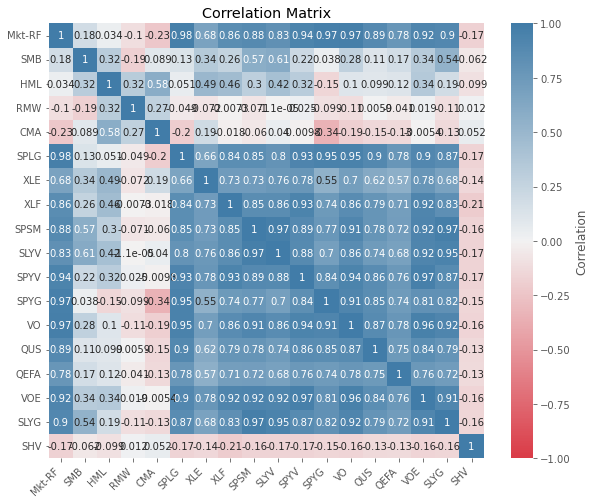

In [11]:
ret = pd.DataFrame()
for i in range(len(tickers)):
    ret[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']] = corr_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
    ret[tickers[i]] = corr_data['R_'+tickers[i]]
    
corr = ret.corr()

fig = plt.subplots(figsize = (10, 8))
fig = sns.heatmap(
    corr, 
    vmin = -1, vmax = 1, center = 0,
    cmap = sns.diverging_palette(10, 240, n = 256),
    square = True,
    annot = True,
    cbar_kws={'label': 'Correlation'},
    xticklabels = True,
    yticklabels = True
)

fig.set_xticklabels(
    fig.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right'
)

fig.set_yticklabels(
    fig.get_yticklabels(),
    rotation = 0
)

plt.title('Correlation Matrix')

plt.show()

In [12]:
date_range(ret)

Date Range: 2015-04-17 to 2022-03-31


In [13]:
# Fama-French returns and stdevs
mkt_r = list(fama_french['Mkt-RF'])
small = list(fama_french['SMB'])
value = list(fama_french['HML'])
profit = list(fama_french['RMW'])

market = np.mean(mkt_r)*252
mkt_stdev = np.std(mkt_r)*252**.5

small_r = np.mean(small)*252
small_stdev = np.std(small)*252**.5

value_r = np.mean(value)*252
value_stdev = np.std(value)*252**.5

profit_r = np.mean(profit)*252
profit_stdev = np.std(profit)*252**.5

table = [['', 'Return (%)', 'Stdev (%)', 'Sharpe'], ['Market', round(market*100,2), round(mkt_stdev*100,2), round(market/mkt_stdev, 2)],
        ['Small-cap. Stocks', round(small_r*100,2), round(small_stdev*100,2), round(small_r/small_stdev, 2)],
        ['Value Stocks', round(value_r*100,2), round(value_stdev*100,2), round(value_r/value_stdev, 2)],
        ['Profitable Stocks', round(profit_r*100,2), round(profit_stdev*100,2), round(profit_r/profit_stdev, 2)]]

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))
fama_french_dates(fama_french)

╒═══════════════════╤══════════════╤═════════════╤══════════╕
│                   │   Return (%) │   Stdev (%) │   Sharpe │
╞═══════════════════╪══════════════╪═════════════╪══════════╡
│ Market            │         7.03 │       16.11 │     0.44 │
├───────────────────┼──────────────┼─────────────┼──────────┤
│ Small-cap. Stocks │         1.86 │        8.58 │     0.22 │
├───────────────────┼──────────────┼─────────────┼──────────┤
│ Value Stocks      │         3.7  │        9.03 │     0.41 │
├───────────────────┼──────────────┼─────────────┼──────────┤
│ Profitable Stocks │         3.38 │        6.16 │     0.55 │
╘═══════════════════╧══════════════╧═════════════╧══════════╛
Date Range: 1963-07-01 to 2022-03-31


## Eliminating Variables with no Statistical Significance

In order to be distinguishable from zero, the variable needs to have a t-stat greater than 1.96 or less than -1.96. T-stats are simply the coefficient divided by the standard error. This normalizes the data making 0 the mean. 1.96 and -1.96 are the critical values of the normal distribution at the 5% significance level. Therefore, we can claim that, at the 5% significance level, any value outside of this range has statistical significance and can be distiguished from zero. In other words, this doesn't appear to be a random relationship.

In [14]:
p = portfolio.copy()

In [15]:
p.loc[(p['T_Alpha'] <= 1.96) & (p['T_Alpha'] >= -1.96), 'Alpha'] = 0
p.loc[(p['T_Beta_m'] <= 1.96) & (p['T_Beta_m'] >= -1.96), 'Beta_m'] = 0
p.loc[(p['T_Beta_SMB'] <= 1.96) & (p['T_Beta_SMB'] >= -1.96), 'Beta_SMB'] = 0
p.loc[(p['T_Beta_HML'] <= 1.96) & (p['T_Beta_HML'] >= -1.96), 'Beta_HML'] = 0
p.loc[(p['T_Beta_RMW'] <= 1.96) & (p['T_Beta_RMW'] >= -1.96), 'Beta_RMW'] = 0
p.loc[(p['T_Beta_CMA'] <= 1.96) & (p['T_Beta_CMA'] >= -1.96), 'Beta_CMA'] = 0
p = p[['Ticker', 'Weight', 'Alpha', 'Beta_m', 'Beta_SMB', 'Beta_HML', 'Beta_RMW', 'Beta_CMA']]
p

,Ticker,Weight,Alpha,Beta_m,Beta_SMB,Beta_HML,Beta_RMW,Beta_CMA
0,SPLG,18.0,0.000000,0.817354,-0.051451,0.053735,0.000000,-0.087784
1,XLE,5.0,0.000000,1.071699,0.189531,0.486211,0.460363,0.312207
2,XLF,5.0,0.000000,1.182336,-0.259518,1.083127,-0.141447,-0.388075
3,SPSM,10.0,0.000000,0.989745,0.843065,0.195116,0.120245,0.000000
4,SLYV,5.0,0.000000,0.939979,0.789723,0.401271,0.243080,0.071874
5,SPYV,10.0,0.000000,0.886142,-0.047081,0.297987,0.162279,0.194172
6,SPYG,12.0,0.000000,0.968473,-0.081862,-0.175547,-0.049351,-0.151879
7,VO,6.0,0.000000,1.029125,0.191019,0.041789,0.000000,-0.036859
8,QUS,5.0,0.000000,0.847029,-0.098050,0.067552,0.144204,0.000000
9,QEFA,10.0,0.000000,0.672330,0.000000,0.100587,0.000000,0.000000


In [16]:
alpha = np.sum((p['Weight']/100) * p['Alpha'])
m = np.sum((p['Weight']/100) * p['Beta_m'])
s = np.sum((p['Weight']/100) * p['Beta_SMB'])
v = np.sum((p['Weight']/100) * p['Beta_HML'])
p = np.sum((p['Weight']/100) * p['Beta_RMW'])
# t = np.sum((p['Weight']/100) * p['Beta_CMA'])

portfolio_coef = [['', 'Alpha', 'Beta_m', 'Beta_SMB', 'Beta_HML', 'Beta_RMW'],
        [f"{name}", round(alpha, 5), round(m, 5), round(s, 5), round(v, 5), round(p, 5)]]

print(tabulate(portfolio_coef, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════╤═════════╤══════════╤════════════╤════════════╤════════════╕
│     │   Alpha │   Beta_m │   Beta_SMB │   Beta_HML │   Beta_RMW │
╞═════╪═════════╪══════════╪════════════╪════════════╪════════════╡
│ IRA │       0 │  0.87122 │    0.13672 │    0.16975 │    0.06112 │
╘═════╧═════════╧══════════╧════════════╧════════════╧════════════╛


In [17]:
expected_return = alpha + (market * m) + (small_r * s) + (value_r * v) + (profit_r * p)
expected_stdev = (mkt_stdev * m) + (small_stdev * s) + (value_stdev * v) + (profit_stdev * p)

portfolio_returns = [['', 'Return', 'Sigma', 'Sharpe Ratio', 'Treynor Ratio'],
        [f"{name}", f"{round(expected_return*100, 2)}%", f"{round(expected_stdev*100, 2)}%",
         f"{round(expected_return/expected_stdev, 2)}", f"{round(expected_return/m, 2)}"]]

print(tabulate(portfolio_returns, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════╤══════════╤═════════╤════════════════╤═════════════════╕
│     │ Return   │ Sigma   │   Sharpe Ratio │   Treynor Ratio │
╞═════╪══════════╪═════════╪════════════════╪═════════════════╡
│ IRA │ 7.22%    │ 17.11%  │           0.42 │            0.08 │
╘═════╧══════════╧═════════╧════════════════╧═════════════════╛


## MC Analysis

Running a simulation for one million possible futures and taking the average return of said million will give a nice picture as to how this portfolio might return over x number of years. This is of course 100% reliant on history and therefore is no guarantee of the future. It simply acts as a way to judge the risk-return trade-off you can expect by utilizing this portfolio.

In [18]:
wealth = []
x = 1000000
futures = "{:,}".format(x)

while True:
    try:
        invest_type = str(input("Is this a 'one-time' or 'annual' investment? "))
        
        if invest_type == "annual":
            recurring = float(input("What dollar amount will you be investing in this portfolio annually? "))
        
        elif invest_type == "one-time":
            recurring = 0
            investment = float(input("How much will you be investing? "))
        else:
            fail
        
        years = float(input("How many years will you utilize this portfolio? "))
        years = int(years)
        break
    except Exception:
        print('Enter a valid type or number')

print(f"Generating {futures} possible futures...")

for i in range(x):
    if invest_type == "annual":
        ending = 0
        
    else:
        ending = investment
    
    for j in range(years):
        ending = recurring + ending * (1 + random.gauss(expected_return, expected_stdev))

    wealth.append(ending)

if invest_type == "annual":
    total_contrib = recurring * years
else:
    total_contrib = investment

total = "{:,}".format(total_contrib)

ending_value = round(np.mean(wealth), 2)
end = "{:,}".format(ending_value)

stdev = round(np.std(wealth), 2)
stdev = "{:,}".format(stdev)

total_return = round(((ending_value/total_contrib) - 1) * 100, 2)
ret = "{:,}".format(total_return)
annualized = round(total_return/years, 2)

# print(f"Total Contribution: ${total} | Average Ending Balance: ${end} | Standard Deviation: ${stdev}")
# print(f"Total Return: {ret}% | Annualized: {annualized}%")


return_table = [['Portfolio Name', 'Total Contribution', 'Avg. Balance', 'Stdev', 'Total Return', 'Annualized'],
        [f"{name}", f"${total}", f"${end}", f"${stdev}", f"{ret}%", f"{annualized}%"]]

print(tabulate(return_table, headers = 'firstrow', tablefmt = 'fancy_grid'))

Is this a 'one-time' or 'annual' investment? one-time
How much will you be investing? 200000
How many years will you utilize this portfolio? 30
Generating 1,000,000 possible futures...
╒══════════════════╤══════════════════════╤════════════════╤═══════════════╤════════════════╤══════════════╕
│ Portfolio Name   │ Total Contribution   │ Avg. Balance   │ Stdev         │ Total Return   │ Annualized   │
╞══════════════════╪══════════════════════╪════════════════╪═══════════════╪════════════════╪══════════════╡
│ IRA              │ $200,000.0           │ $1,618,177.04  │ $1,725,660.32 │ 709.09%        │ 23.64%       │
╘══════════════════╧══════════════════════╧════════════════╧═══════════════╧════════════════╧══════════════╛


In [ ]:
# Next - line chart of each MC result?